In [130]:
#2017年の中学生のデータを取り込み
import pandas as pd
df = pd.read_csv('pref_2017.csv')
df.head()

,2017,f_rate,gaku,life,sports,morals,jison
0,Hokkaido,3.39,65.0,5.10,40.70,4.9,5.1
1,Aomori,2.99,66.3,5.25,42.28,5.3,5.4
2,Iwate,2.56,63.8,5.20,44.22,5.5,5.1
3,Miyagi,4.34,65.0,5.35,42.01,4.8,5.0
4,Akita,2.45,70.0,6.15,44.22,5.9,5.9


In [131]:
#都道府県と不登校率の列は不要なので削除
df_1 = df.drop(['2017', 'f_rate'], axis = 1)
df_1.head()

,gaku,life,sports,morals,jison
0,65.0,5.10,40.70,4.9,5.1
1,66.3,5.25,42.28,5.3,5.4
2,63.8,5.20,44.22,5.5,5.1
3,65.0,5.35,42.01,4.8,5.0
4,70.0,6.15,44.22,5.9,5.9


In [132]:
#データを標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc_df = sc.fit_transform(df_1)

In [133]:
#tsneの実行
from sklearn.manifold import TSNE
tsne = TSNE(random_state=0).fit_transform(sc_df)

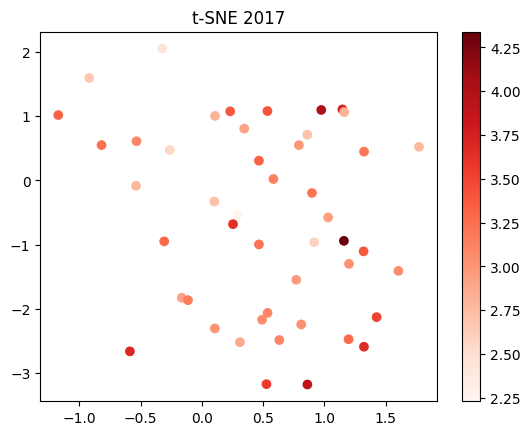

In [134]:
#tsneの結果を不登校率で色分けしてプロット
import matplotlib.pyplot as plt
plt.scatter(tsne[:, 0], tsne[:, 1],cmap='Reds', c = df['f_rate'])
plt.title('t-SNE 2017')
plt.colorbar()
plt.show()

In [135]:
#PCAで次元削減
from sklearn.decomposition import PCA
pca = PCA()
#新規列への学習と当てはめ
new = pca.fit_transform(sc_df)
#寄与率の計算
pca.explained_variance_ratio_ #この結果から、上位2つで0.78なことがわかる

array([0.60974945, 0.173548  , 0.13473471, 0.05370602, 0.02826182])

In [136]:
#PCAの結果をデータフレームにして確認
new_1 = pd.DataFrame(new)
new_1.head()

,0,1,2,3,4
0,-0.772184,-0.680411,0.827958,-0.331676,-0.443648
1,1.210098,-0.369818,0.486229,0.221994,-0.396162
2,1.011080,-0.710106,-1.449223,0.391216,0.630100
3,-0.402419,-0.291129,0.044672,-1.180107,-0.283387
4,5.457548,0.177311,0.873331,-0.563124,-0.086086


In [137]:
#可視化のため０と１だけ抽出して列名を'PC1', 'PC2'と変更
new_df = new_1[[0, 1]]
new_df.columns = ['PC1', 'PC2']

/Users/yumikomabuchi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yumikomabuchi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yumikomabuchi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yumikomabuchi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

<Axes: >

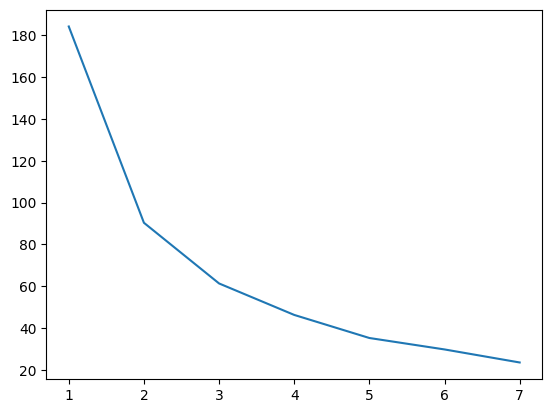

In [141]:
#クラスタをいくつにするか確認するためにSSE(誤差平方和)を計算する
from sklearn.cluster import KMeans
see_list = []
for n in range(1,8):
    kmeans = KMeans(n_clusters = n, random_state = 0)
    kmeans.fit(new_df)
    see = kmeans.inertia_
    see_list.append(see)
se = pd.Series(see_list)
num = range(1,8)
se.index = num
se.plot(kind = 'line')

In [ ]:
#2次元に圧縮したデータでクラスを3にしてクラスタリングを実行
kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(new_df)
clusters = kmeans.labels_

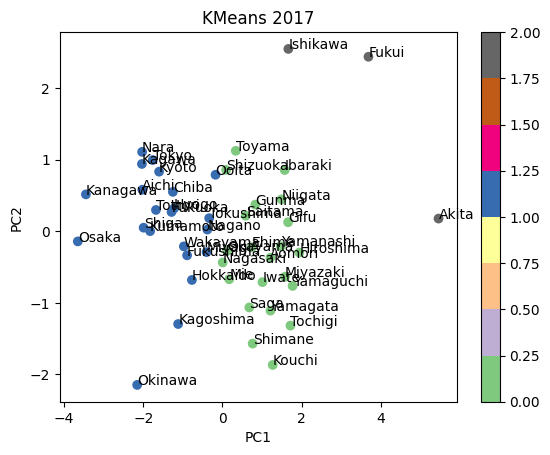

In [144]:
#KMeansでのクラスタ毎に色分けしてプロット
plt.scatter(new_df['PC1'], new_df['PC2'], c=clusters, cmap='Accent')
plt.title('KMeans 2017')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
#都道府県ラベルの表示
for i, label in enumerate(df['2017'].values):
    plt.annotate(label, (new_df['PC1'].values[i], new_df['PC2'].values[i]))

plt.show()

In [145]:
#相関係数を計算するために標準化済のもとのデータと主成分分析したデータを結合する
df2 = pd.DataFrame(sc_df, columns = df_1.columns)
df3 = pd.concat([df2, new_df], axis = 1)

In [147]:
#相関係数の表示
df_corr = df3.corr()
df_corr.loc[:'jison', 'PC1':]

,PC1,PC2
gaku,0.513920,0.741065
life,0.877052,-0.210570
sports,0.612320,0.394405
morals,0.894142,-0.269763
jison,0.917054,-0.214233


<Axes: xlabel='clusters'>

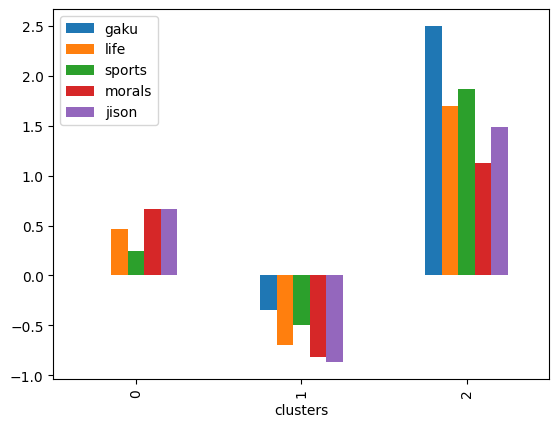

In [148]:
#クラスによってどんな特徴があるのか、クラス毎で平均を出してグラフ化
#標準化済のデータをデータフレームにして、クラスタリング結果の列を追加
sc_df = pd.DataFrame(sc_df, columns = df_1.columns)
sc_df['clusters'] = clusters
#クラス毎の平均を出して棒グラフに表示する
clusters_mean = sc_df.groupby('clusters').mean()
clusters_mean.plot(kind = 'bar')
